In [114]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [115]:
cpi_data_refined = pd.read_csv('CPI Refined Data.csv', parse_dates={'Date':['DATE']})
original = cpi_data_refined[['Date', 'CPIH ALL ITEMS']]
train_dates = pd.to_datetime(cpi_data_refined['Date'])
cpi_data_refined.set_index('Date', inplace=True)

In [116]:
cpi_data_refined.columns

Index(['CPIH ALL ITEMS', 'FOOD AND NON-ALCOHOLIC BEVERAGES',
       'ALCOHOLIC BEVERAGES AND TOBACCO', 'CLOTHING AND FOOTWEAR',
       'FURNITURE, HOUSEHOLD EQUIPMENT AND MAINTENANCE', 'HEALTH', 'TRANSPORT',
       'ELECTRICITY, GAS AND OTHER FUELS', 'COMMUNICATION',
       'RECREATION & CULTURE', 'EDUCATION', 'RESTAURANTS AND HOTELS',
       'MISCELLANEOUS GOODS AND SERVICES'],
      dtype='object')

In [117]:
cpi_data_refined.drop('CLOTHING AND FOOTWEAR',axis=1,inplace=True)

In [118]:
cpi_data_pre_covid = cpi_data_refined[:384]

# DROP COVID 19 DATES

In [119]:
# Scale the Data
scaler = StandardScaler()
scaler = scaler.fit(cpi_data_pre_covid)
df_scaled_cpi = scaler.transform(cpi_data_pre_covid)

In [120]:
# reshape input data
trainX = []
trainY = []

n_future = 1
n_past = 4

# setup for multivariate LSTM, we must get input data ready


for i in range(n_past, len(df_scaled_cpi) - n_future+1):
    trainX.append(df_scaled_cpi[i-n_past:i, 0:df_scaled_cpi.shape[1]])
    trainY.append(df_scaled_cpi[i +n_future-1:i+n_future, 0])

trainX,trainY = np.array(trainX), np.array(trainY)


# trainX[0] represents the no. of datapoints we have for training. We are holding back 4 months (see n_past=4)
# trainX[1] represents the number of days we are looking back (4)
# trainX[2] represents number of variables 

print(trainX.shape)
print(trainY.shape)

(380, 4, 12)
(380, 1)


In [121]:
print(len(trainX))

380


## Define Model

In [331]:
model = Sequential()
model.add(LSTM(64,activation='relu', input_shape=(trainX.shape[1],trainX.shape[2]), return_sequences=True))
model.add(Dense(32, activation ='relu'))
model.add(Dropout(0.25))
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1],trainX.shape[2]), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])

model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 4, 64)             19712     
                                                                 
 dense_45 (Dense)            (None, 4, 32)             2080      
                                                                 
 dropout_45 (Dropout)        (None, 4, 32)             0         
                                                                 
 lstm_47 (LSTM)              (None, 64)                24832     
                                                                 
 dropout_46 (Dropout)        (None, 64)                0         
                                                                 
 dense_46 (Dense)            (None, 1)                 65        
                                                                 
Total params: 46,689
Trainable params: 46,689
Non-tra

In [332]:
# print(len(cpi_data_refined))

testX = df_scaled_cpi[408:]
print(len(testX))
print(df_scaled_cpi.shape)

0
(384, 12)


# Fit Model

In [333]:
history = model.fit(trainX[:368], trainY[:368], epochs=15, batch_size=16,validation_split=0.1, verbose=0)

In [334]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


# Check for overfitting

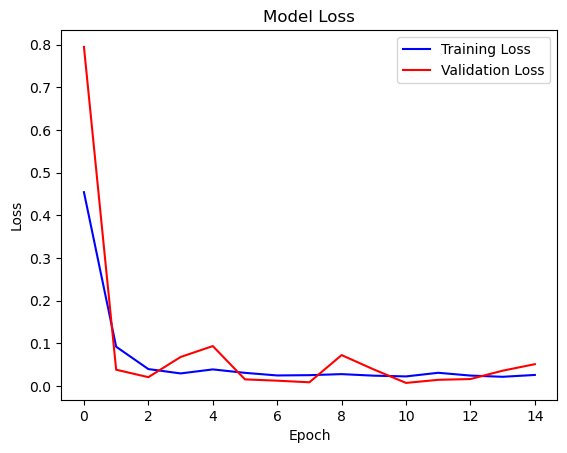

In [321]:
plt.plot(history.history['loss'], label = 'Training Loss', color = 'Blue')
plt.plot(history.history['val_loss'], label = 'Validation Loss', color = 'Red')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [322]:
# print(history.history['mean_squared_error'])
# print(history.history['val_mean_squared_error'])

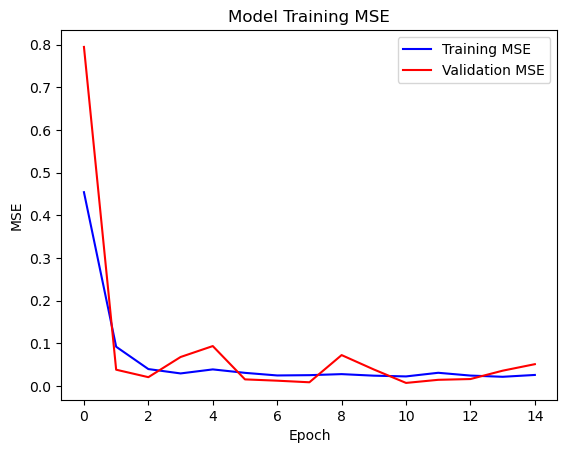

In [323]:
# Plot the training accuracy
plt.plot(history.history['mean_squared_error'],label = 'Training MSE', color = 'Blue')
plt.plot(history.history['val_mean_squared_error'], label = 'Validation MSE', color = 'Red')
plt.title('Model Training MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Forecast

- I want to try and forecast 3 months in advance

In [324]:
n_past = 12
#im trying to predict the past 3 months
n_months_for_prediction = 12
forecast_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_months_for_prediction, freq='m').tolist()

In [325]:
arr=[1,2,3,4,5,6,7,8,9]
print(arr[-4:])

[6, 7, 8, 9]


In [326]:
forecast = model.predict(trainX[368:])
# forecast = model.predict(testX)

1/1 [==============================] - 1s 676ms/step


In [327]:
#we need to perform an inverse transformation to go back to original range
print(len(forecast))
print(forecast)

12
[[1.4971681]
 [1.5019137]
 [1.5111904]
 [1.5170907]
 [1.5147873]
 [1.5463778]
 [1.5552634]
 [1.5634276]
 [1.5778176]
 [1.5830346]
 [1.5840936]
 [1.5915823]]


In [328]:
forecast_transform = np.repeat(forecast, cpi_data_refined.shape[1],axis=-1)
cpi_prediction = scaler.inverse_transform(forecast_transform)[:,0]

In [329]:
print(cpi_prediction)

[104.095894 104.173775 104.32602  104.422844 104.38504  104.90347
 105.04929  105.18327  105.419426 105.50504  105.522415 105.64532 ]


# Evaluation

In [330]:
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
#mse
actual_cpi = cpi_data_pre_covid['CPIH ALL ITEMS'][-n_months_for_prediction:]


mse = mean_squared_error(actual_cpi, cpi_prediction)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_cpi, cpi_prediction)

# model_error = abs(actual_cpi - cpi_prediction)
# print('Mean Model Error: ', model_error.mean())


print('Model Performance')
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

Model Performance
MSE:  8.601540689278083
RMSE:  2.9328383333007095
MAE:  2.9174322458902986


In [275]:
# observed = cpi_data_refined.loc['2022-10-01':'2022-12-01',['CPIH ALL ITEMS']]
# observed.plot(color = 'SteelBlue', title = 'Actual', legend = False)
# plt.show()

# # print(testY_hat)

# predicted = pd.DataFrame(cpi_prediction, index=pd.date_range('2022-10-01',periods=4,freq='M'))
# predicted.plot(color = 'Firebrick', title = 'Forecasted', legend = False)
# plt.show()

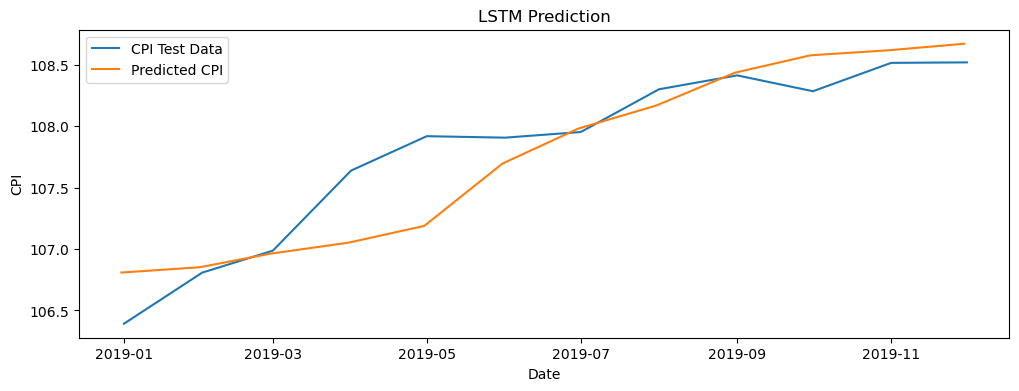

In [171]:
predicted = pd.DataFrame(cpi_prediction, index=pd.date_range('2018-12-01',periods=12,freq='M'))

plt.figure(figsize=(12,4))
plt.plot(cpi_data_pre_covid.loc['2019-01-01':'2019-12-01']['CPIH ALL ITEMS'], label="CPI Test Data")
# plt.plot(cpi_data_pre_covid.loc['2015-01-01':'2019-01-01']['CPIH ALL ITEMS'], label='CPI Training Data')
plt.plot(predicted, label="Predicted CPI")
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend(loc='best')
plt.title('LSTM Prediction')
plt.show()

## Out of Sample Forecasting